In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Function:
    def __init__(self, name = ""):
        self.output = 0
        self.name = name
    
    def __call__(self, X):
        pass

    def grad(self):
        pass
    
    def string(self):
        pass

class Sigmoid(Function):
    def __init__(self):
        super().__init__("Sigmoid")
    
    def __call__(self, X):
        self.output = 1 / (1 +np.exp(-X))
        return self.output
    
    def grad(self):
        return self.output * (1 - self.output)

    def string(self):
        return self.name
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name

class Tanh(Function):
    def __init__(self):
        super().__init__("Hyperbolic Tangent")
    
    def __call__(self, X):
        self.output = np.tanh(X)
        return self.output
    
    def grad(self):
        return 1 - self.output ** 2
    
    def string(self):
        return self.name
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
    
class ReLU(Function):
    def __init__(self):
        super().__init__("Recirtified Linear Unit")
    
    def __call__(self, X):
        self.output = np.maximum(0, X)
        return self.output
    
    def grad(self):
        return np.where(self.output > 0, 1, 0)
    
    def string(self):
        return self.name
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
    
class Leaky_ReLU(Function):
    def __init__(self):
        super().__init__("Leaky ReLU")
    
    def __call__(self, X):
        self.output = np.maximum(0.01 * X, X)
        return self.output
    
    def grad(self):
        return np.where(self.output > 0, 1, 0.01)
    
    def string(self):
        return self.name
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
    
class Identity(Function):
    def __init__(self):
        super().__init__("Identity")
        
    def __call__(self, X):
        return X
    
    def grad(self):
        return 1

    def string(self):
        return self.name
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
    
class MSE:
    def __init__(self):
        super().__init__("Mean Squared Error")
        
    def __call__(self, Y, Y_hat):
        self.diff = Y - Y_hat
        self.output = np.square(self.diff).mean()
        return self.output
    
    def grad(self):
        return self.diff

    def string(self):
        return self.name
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name

In [2]:
import pprint
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from itertools import permutations

class Layer:
    def __init__(self, input_size, output_size, activation : Function, alpha = 0.001):
        self.input_size = input_size
        self.output_size = output_size
        self.weight = np.random.randn(output_size, input_size) * np.sqrt(1. / output_size)
        self.bias = np.random.randn(output_size, 1)
        self.activation = activation
        self.alpha = alpha

    def forward(self, _a):
        self.x = _a
        self.z = np.dot(self.weight, _a) + self.bias
        self.a = self.activation(self.z)
        return self.a

    def backward(self, diff):
        error = diff * self.activation.grad()
        dw = np.outer(error, self.x)
        diff = np.dot(self.weight.T, error)
        return diff, dw
    
class Sequential:
    def __init__(self, layers = [], epochs = 1000, alpha = 0.001):
        self.pp = pprint.PrettyPrinter(indent=4)
        self.alpha = alpha
        self.layers = layers
        self.epochs = epochs
        self.desc = f"----------Sequential----------\nAlpha : {alpha}, Epochs : {epochs}\nCost Function : Mean Squared Error\n"
        self._model = {}
    
    def add(self, input_size, output_size, activation : Function):
        activation_func = activation()
        self.layers.append(Layer(input_size, output_size, activation_func, self.alpha))
        layer_desc = "\t".join([f"Input size : {input_size:>5}", f"Output size : {output_size:>5}", f"Activation : {activation_func.string()}"]) + '\n'
        self.desc += layer_desc
        
    def compile(self):
        self._model['layers'] = self.layers
        self.desc += "------------------------------"
        self.summary()
        return self
    
    def graph_init(self):
        self.G = nx.DiGraph()
        self.edges = []
        nodes = []
        num_nodes = 0
        for layer in self._model['layers']:
            input_size = layer.input_size + 1
            nodes.append(range(num_nodes, num_nodes + input_size))
            num_nodes += input_size
        num_nodes += self._model['layers'][-1].output_size
        nodes.append(range(num_nodes, num_nodes + self._model['layers'][-1].output_size))
        
        for i in range(len(nodes) - 1):
            from_nodes = nodes[i]
            to_nodes = nodes[i+1]
            first_from_node = from_nodes[0]
            first_to_node = to_nodes[0] + 1
            param = np.concatenate((self._model['params'][i]['b'], self._model['params'][i]['w']), axis=1)
            for idx, to_node in enumerate(to_nodes):
                if idx == 0:
                    continue
                for from_node in from_nodes:
                    weight = param[to_node - first_to_node][from_node - first_from_node]
                    self.edges.append([from_node, to_node, weight])
                    
        self.g_nodes = nodes
        
    def plot_graph(self):
        
        self.G.add_weighted_edges_from(self.edges)

        pos_idx = 0
        
        pos = {}
        
        for nodes in self.g_nodes:
            for node, i in zip(nodes, range(len(nodes))):
                pos[node] = [pos_idx, (i - len(nodes) / 2) * -(len(self.G.nodes) * 2000)]
            pos_idx += (len(self.G.nodes) * 10000)
        nx.draw(self.G, with_labels=True,pos=pos, font_weight='bold')

        all_weights = []
        for (node1,node2,data) in self.G.edges(data=True):
            all_weights.append(data['weight'])

        unique_weights = list(set(all_weights))

        for weight in unique_weights:
            weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in self.G.edges(data=True) if edge_attr['weight']==weight]
            width = weight*len(self.g_nodes) * 3. / sum(all_weights)
            nx.draw_networkx_edges(self.G,pos, edgelist=weighted_edges, width=width)
        
    def feed_forward(self, X):
        _a = X
        for idx, layer in enumerate(self._model['layers']):
            _a = layer.forward(_a)
        output = _a
        return output
    
    def back_propagation(self, Y, Y_hat):
        diff = (Y_hat - Y) / Y_hat.shape[0]
        to_update = []
        for idx, layer in reversed(list(enumerate(self._model['layers']))):
            diff, dw = layer.backward(diff)
            to_update.append(dw)
            
        for dw, layer in zip(reversed(to_update), self._model['layers']):
            layer.weight -= self.alpha * dw
        
    def predict(self, X):
        out = []
        for x in X:
            out.append(self.feed_forward(x))
        return np.array(out)
    
    def fit(self, X, Y, early_stopping = -1, print_jump = 1, history=False):
        mse_history = []
        for epoch in range(self.epochs):
            mse = []
            y_pred = []
            for x, y in zip(X, Y):
                y_hat = self.feed_forward(x)
                y_pred.append(y_hat)
                mse.append((y - y_hat) ** 2)
                self.back_propagation(y, y_hat)
            mse = np.array(mse).mean()
            
            if epoch == 0:
                self.first_mse = mse
            
            if epoch % print_jump == 0:
                mse_history.append(mse)
                print(f'Epoch : {epoch} | MSE : {mse}')
                if history:
                    self.plot_progress(X, Y, y_pred, self.epochs, mse_history, print_jump)
            
            if mse < early_stopping:
                print(f'\n{epoch} epoch spent. Early stop by MSE ({mse}) < {early_stopping}.\n')
                break
    
    def result(self, graph=False):
        self._model['params'] = []
        for layer in self._model['layers']:
            w = layer.weight
            b = layer.bias
            self._model['params'].append({'w' : w, 'b' : b})
        
        self.graph_init()
        self.plot_graph()
        self.G.clear()
        #self.pp.pprint(self._model['params'])
    
    def summary(self):
        print(self.desc)
        
    def plot_progress(self, x, y, y_hat, epochs, mse, print_jump):
        fig, axs = plt.subplots(1, 2, figsize=(16, 8))
        ax1 = axs[0]
        ax2 = axs[1]
        ax1 = plt.subplot(1, 2, 1)
        ax1.scatter(x, y, s=2)
        ax1.scatter(x, y_hat, s=2)

        ax2 = plt.subplot(1, 2, 2)
        ax2.set_xlim([-10, self.epochs +10])
        ax2.set_ylim([0, mse[0]/10])
        ax2.plot(range(0, epochs, print_jump)[:len(mse)], mse)
        ax2.set_title(f'MSE : {mse[-1]}')
        plt.tight_layout()
        plt.savefig('figure'+f'{len(mse)}'.zfill(4))
        plt.show()

----------Sequential----------
Alpha : 0.001, Epochs : 2000
Cost Function : Mean Squared Error
Input size :     1	Output size :     5	Activation : Hyperbolic Tangent
Input size :     5	Output size :     5	Activation : Hyperbolic Tangent
Input size :     5	Output size :     5	Activation : Hyperbolic Tangent
Input size :     5	Output size :     1	Activation : Identity
------------------------------
Epoch : 0 | MSE : 0.5518347314752376
Epoch : 1000 | MSE : 0.020990317489139553


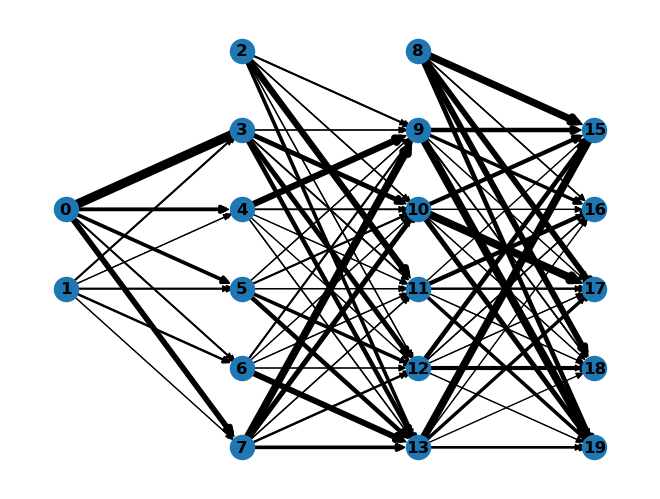

In [3]:
sine = Sequential(epochs = 2000, alpha = 0.001)

input_size = 1
output_size = 1
sine.add(input_size, 5, Tanh)
sine.add(5, 5, Tanh)
sine.add(5, 5, Tanh)
sine.add(5, output_size, Identity)
sine.compile()

X=np.linspace(-10, 10, 1000)
y=np.sin(X)

sine.fit(X, y, early_stopping=0.0003, print_jump=1000)

sine.result(graph=True)

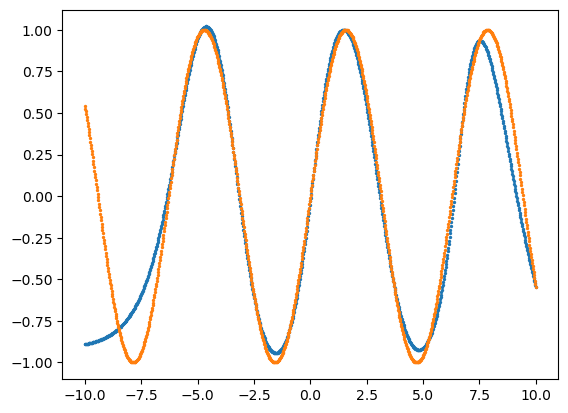

In [4]:
y_pred = sine.predict(X)

plt.scatter(X, y_pred, s=2)
plt.scatter(X, y, s=2)
plt.show()